# 1️⃣ 라이브러리 및 패키지 확인

In [1]:
import tensorflow
import numpy
import transformers
import datasets
from datasets import load_dataset
from datasets import DatasetDict

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


In [2]:
# 로딩 중 로그 출력 최소화 (로딩바 포함)
import datasets
datasets.logging.set_verbosity_error()  # 모든 로깅 출력 (로딩바 포함)을 끔

# 실제 데이터셋 불러오기
nsmc_dataset = load_dataset('e9t/nsmc')

# 데이터셋 전체 구조 출력 (train/validation/test로 나뉜 dict 형태)
print(nsmc_dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


### ✅ 체크포인트 : 데이터 구성요소 분석

---

데터셋은 DatasetDict 형태로 train, test 가 존재하는 것을 알 수 있음.

`train` : 150000개의 데이터, `id`,`document`,`label` 이 존재한다.
`test` : 50000개의 데이터, `id`,`document`,`label` 이 존재한다.

**Validation Set을 나눠줘야겠다. 학습용으로**

In [5]:
# train 데이터를 90% 학습용 / 10% 검증용으로 나눔
# 일반적으로 10% 정도 사용한다고 한다.
nsmc_split = nsmc_dataset['train'].train_test_split(test_size=0.1, seed=42)

# 새롭게 구성된 데이터셋 딕셔너리로 저장
nsmc_dataset = {
    'train': nsmc_split['train'],
    'validation': nsmc_split['test'],
    'test': nsmc_dataset['test']
}

print(nsmc_dataset)

{'train': Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 135000
}), 'validation': Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 15000
}), 'test': Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 50000
})}


In [6]:
# 클래스 불균형 확인하기

from collections import Counter

# train split에서 label 추출
train_labels = nsmc_dataset['train']['label']

# 각 클래스 개수 세기
label_counts = Counter(train_labels)

# 출력
print(f"Negative (0): {label_counts[0]}")
print(f"Positive (1): {label_counts[1]}")

Negative (0): 67703
Positive (1): 67297


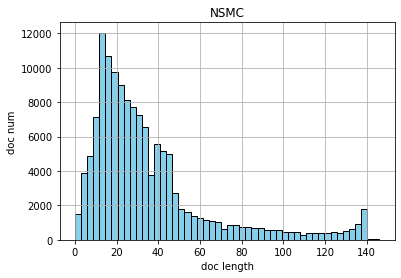

In [7]:
import matplotlib.pyplot as plt

# 1. 문장 길이 측정
train_docs = nsmc_dataset['train']['document']
lengths = [len(doc) for doc in train_docs]  # 각 문장의 문자 수

# 2. 히스토그램 그리기
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("NSMC")
plt.xlabel("doc length")
plt.ylabel("doc num")
plt.grid(True)
plt.show()

In [8]:
import numpy as np

# 1. 길이 리스트 생성 
lengths = [len(doc) for doc in nsmc_dataset['train']['document']]

# 2. 평균 및 표준편차 계산
mean_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"📌 평균 문장 길이: {mean_length:.2f}")
print(f"📌 표준편차: {std_length:.2f}")

# 3. 누적 분포를 기준으로 90% 커버하는 길이 구하기
percentile_90 = np.percentile(lengths, 90)  # 전체 문장 중 90%가 이 길이 이내

print(f"📌 90%의 문장을 포함하기 위한 최소 길이: {percentile_90:.0f}")

📌 평균 문장 길이: 35.19
📌 표준편차: 29.57
📌 90%의 문장을 포함하기 위한 최소 길이: 75


### ✅ 체크포인트 : NSMC 데이터가 어떤 데이터인지 파악

---
#### 데이터 구조
NSMC는 다음과 같은 데이터 특성을 가지고 있다.

`ID` : 고유 번호
`Document` : 리뷰 텍스트 데이터
`Label` : 감성분류 1은 긍정 0은 부정

#### 클래스 불균형 여부
클래스 불균형은 거의 없다고 보면 된다.

#### 문장길이 분포 

📌 평균 문장 길이: 35.20

📌 표준편차: 29.58

📌 90%의 문장을 포함하기 위한 최소 길이: 75

# 2️⃣ Tokenizer & Model

---

만약에 허깅페이스에 데이터셋이 없다면 Tensorflow_dataset에서 불러와서 Huggingface 에 맞게 바꾸는 과정을 하겠지만 충분히 있으므로 허깅페이스 데이터로 그래도 진행한다.

현재 노드에서는 `Klue/Bert Model` 및 토크나이저를 `AutoTokenizer`에 맞게 진행할거임.

In [12]:
# Hugging Face의 transformers 라이브러리에서 필요한 클래스 불러오기
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 🔹 1. Tokenizer 불러오기

huggingface_tokenizer = AutoTokenizer.from_pretrained('./nsmc-klue-bert-finetuned')

# 🔹 2. 모델 불러오기 (분류용)

huggingface_model = AutoModelForSequenceClassification.from_pretrained(
    './nsmc-klue-bert-finetuned',  # 사전 학습된 klue/bert-base 모델 사용
    num_labels=2                # 출력 클래스 수: 2개 (0 또는 1)
)


Didn't find file ./nsmc-klue-bert-finetuned/added_tokens.json. We won't load it.
loading file ./nsmc-klue-bert-finetuned/vocab.txt
loading file ./nsmc-klue-bert-finetuned/tokenizer.json
loading file None
loading file ./nsmc-klue-bert-finetuned/special_tokens_map.json
loading file ./nsmc-klue-bert-finetuned/tokenizer_config.json
loading configuration file ./nsmc-klue-bert-finetuned/config.json
Model config BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float3

### ✅ 체크포인트 : `AutoTokenizer`와 `AutoModel` 의 기능
---

`AutoTokenizer`, `AutoModel` 기능을 한번 사용해 본거다

```python
huggingface_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
```

 이 명령은 'distilbert-base-uncased' 모델에 최적화된 토크나이저 클래스 (예: DistilBertTokenizerFast)를 자동으로 로드해서 `huggingface_tokenizer`에 할당합니다.

```python
huggingface_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=2                
)
```

여기서는 `AutoModelForSequenceClassification` 해당 사전학습 모델 위에 분류용 헤드가 붙은 구조를 불러온다.

이 부분은 `AutoModelForTokenClassification`, `AutoModelForQuestionAnswering` 등 다양한 task에 따라 모델이 존재한다.


In [13]:
def transform(data):
    # data['document']는 문자열 리스트
    # → batched=True일 경우 한 번에 여러 문장이 들어옴

    # 1. 텍스트 정제 (필요 시)
    texts = data['document']
    # texts = [clean_text(t) for t in texts]

    # 2. 토크나이징
    tokenized = huggingface_tokenizer(
        texts,                         # 리스트 그대로 전달
        truncation=True,
        max_length=75,                # 이전 분석 기반 길이 설정
        padding='max_length',
        return_token_type_ids=False
    )

    # 3. 레이블 추가 (그대로 매칭됨)
    tokenized['label'] = data['label']
    return tokenized

In [14]:
nsmc_dataset = DatasetDict({
    'train': nsmc_split['train'],
    'validation': nsmc_split['test'],
    'test': nsmc_dataset['test']
})

In [15]:
hf_dataset = nsmc_dataset.map(transform, batched=True)

hf_train_dataset = hf_dataset['train']
hf_val_dataset = hf_dataset['validation']
hf_test_dataset = hf_dataset['test']

  0%|          | 0/135 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [16]:
print(set(hf_dataset['train']['label']))  # → {0, 1}이면 OK, {-1}이면 문제
print(set(hf_dataset['test']['label']))  # → {0, 1}이면 OK, {-1}이면 문제

{0, 1}
{0, 1}


### ✅ 체크포인트: map() 함수의 역할
---

🔹 **map() 함수는 무엇을 하나요**

Hugging Face datasets.Dataset 객체에 있는 모든 샘플에 특정 함수를 자동 반복 적용합니다.

반복문을 직접 쓰지 않아도, 내부적으로 최적화된 방식으로 빠르게 데이터를 처리해줍니다.

🔹 **왜 batched=True를 써야 하나요?**

토크나이저(huggingface_tokenizer)는 문장 여러 개를 한꺼번에 처리할 수 있을 때 더 빠르고 효율적입니다.

batched=True를 쓰면 transform() 함수에 여러 샘플이 list 형태로 전달되므로,

→ data['sentence1']는 단일 문장이 아니라 여러 문장의 리스트가 됩니다.

# 4️⃣ Train & Evaluation & Test

In [13]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME') + '/aiffel/transformers/nsmc-klue-bert' 

# TrainingArguments: Trainer에 넘겨줄 학습 설정값 정의
training_arguments = TrainingArguments(
    output_dir,                          # 학습 결과가 저장될 디렉토리
    evaluation_strategy="epoch",        # 매 epoch이 끝날 때마다 평가 실행
    learning_rate=2e-5,                 # 학습률 (learning rate)
    per_device_train_batch_size=64,      # 각 디바이스당 학습 배치 크기
    per_device_eval_batch_size=64,       # 평가 시 배치 크기
    num_train_epochs=3,                 # 학습할 전체 에폭 수
    weight_decay=0.01                   # 가중치 감소 (L2 정규화에 사용)
)


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)  # logits → class index

    return {
        'accuracy': accuracy_score(labels, preds),           # 전체 정확도
        'precision': precision_score(labels, preds),         # 정밀도 (양성으로 예측한 것 중 실제 양성 비율)
        'recall': recall_score(labels, preds),               # 재현율 (실제 양성 중에서 맞춘 비율)
        'f1': f1_score(labels, preds)                        # 정밀도와 재현율의 조화 평균
    }

In [15]:
# Trainer 객체 생성
trainer = Trainer(
    model=huggingface_model,             # KLUE-BERT
    args=training_arguments,             # 학습 설정 인자들
    train_dataset=hf_train_dataset,      # 학습 데이터셋 (토크나이즈 완료)
    eval_dataset=hf_val_dataset,         # 검증 데이터셋
    compute_metrics=compute_metrics      # 평가 함수 (accuracy, F1)
)

In [16]:
trainer.train() # 학습 시작

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 135000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6330


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.248600,0.246010,0.899533,0.881637,0.923904,0.902276
2,0.189800,0.239139,0.905267,0.890451,0.925100,0.907445
3,0.131500,0.269185,0.908467,0.906403,0.911819,0.909103


Saving model checkpoint to /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-

TrainOutput(global_step=6330, training_loss=0.2004366641172677, metrics={'train_runtime': 6965.4757, 'train_samples_per_second': 58.144, 'train_steps_per_second': 0.909, 'total_flos': 1.56093716925e+16, 'train_loss': 0.2004366641172677, 'epoch': 3.0})

### ✅ 체크포인트: 학습 결과
---

결과 적으로 과적합되기전에 완료가 되었지만

`Accuracy` : 0.90846 

`F1`       : 0.909103

요구조건인 정확도 90% 이상은 충족했다.

---

이후에는 현재 Finetunning 된 모델과 가중치들을 저장해 이다음 test 셋에 대해 진행해보아 Acc, F1 을 출력해볼 것이다.

In [19]:
trainer.save_model('./nsmc-klue-bert-finetuned')
huggingface_tokenizer.save_pretrained('./nsmc-klue-bert-finetuned')


Saving model checkpoint to ./nsmc-klue-bert-finetuned
Configuration saved in ./nsmc-klue-bert-finetuned/config.json
Model weights saved in ./nsmc-klue-bert-finetuned/pytorch_model.bin
tokenizer config file saved in ./nsmc-klue-bert-finetuned/tokenizer_config.json
Special tokens file saved in ./nsmc-klue-bert-finetuned/special_tokens_map.json


('./nsmc-klue-bert-finetuned/tokenizer_config.json',
 './nsmc-klue-bert-finetuned/special_tokens_map.json',
 './nsmc-klue-bert-finetuned/vocab.txt',
 './nsmc-klue-bert-finetuned/added_tokens.json',
 './nsmc-klue-bert-finetuned/tokenizer.json')

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained('./nsmc-klue-bert-finetuned')
tokenizer = AutoTokenizer.from_pretrained('./nsmc-klue-bert-finetuned')

In [10]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

In [17]:
from transformers import Trainer

test_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 테스트셋 평가
test_result = test_trainer.evaluate(hf_test_dataset)
print(test_result)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


{'eval_loss': 0.2749262750148773, 'eval_accuracy': 0.90454, 'eval_f1': 0.9059303494353456, 'eval_runtime': 322.0676, 'eval_samples_per_second': 155.247, 'eval_steps_per_second': 19.406}


### ✅ 체크포인트: Eval 결과
---

결과 적으로 과적합되기전에 완료가 되었지만

`Accuracy` : 0.90454

`F1`       : 0.90593

요구조건인 정확도 90% 이상은 충족했다.


# 5️⃣ Bucketing & Dynamic Padding

#### ✅ Dynamic Padding 이란?

동적 패딩(Dynamic Padding)은 각 미니배치(batch)에서 가장 긴 문장을 기준으로 padding을 수행하는 방식입니다.

전체 max_length를 기준으로 하지 않고, 매 배치마다 필요한 만큼만 padding합니다.

`batch = ["나는 간다", "나는 오늘 도서관에 갑니다", "갑니다"]`

- 가장 긴 문장 길이가 8 토큰이면 → batch 내 모든 문장을 8에 맞춰 padding

- 다음 배치가 더 짧은 문장으로 구성되면 → 그 배치에서는 5만큼만 padding

#### ✅ Bucketing이란?

버킷팅(Bucketing)은 문장 길이가 비슷한 샘플끼리 묶어서 batch를 구성하는 전략입니다.
Dynamic Padding의 효율을 더 극대화하기 위한 보조 전략입니다.

`데이터셋 전체: [5토큰, 7토큰, 100토큰, 105토큰, 110토큰, 10토큰...]`

`Bucket 1: [5, 7, 10]`

`Bucket 2: [100, 105, 110]`

→ 비슷한 길이끼리 batch를 구성하면 padding이 거의 필요 없음 → 학습 속도 향상 및 메모리 낭비 감소

In [18]:
# 1. 토크나이저 기반으로 dynamic padding 수행하는 Data Collator 생성
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# → 각 배치마다 가장 긴 문장의 길이에 맞춰 padding을 동적으로 수행
# → Padding 효율을 높여 GPU 메모리 낭비를 줄이고 학습 속도 향상 기대

In [23]:
from transformers import TrainingArguments
import os

# 3. TrainingArguments 정의 (group_by_length 포함)
output_dir = os.getenv('HOME') + '/aiffel/transformers/nsmc-klue-bert' 

training_arguments_bucketing = TrainingArguments(
    output_dir=output_dir,              # 모델과 로그 파일 저장 위치
    evaluation_strategy="epoch",       # 매 epoch 끝날 때마다 validation 평가 수행
    learning_rate=2e-5,                # 학습률
    per_device_train_batch_size=64,    # 학습 시 배치 크기
    per_device_eval_batch_size=64,     # 평가 시 배치 크기
    num_train_epochs=3,                # 학습 epoch 수
    weight_decay=0.01,                 # L2 정규화에 사용되는 가중치 감소 값
    group_by_length=True               # 문장 길이에 따라 유사한 샘플끼리 버킷을 만들어 학습
    # → 이로 인해 동적 패딩 효과가 극대화됨
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [24]:
# 4. Trainer 객체 생성
trainer_bucketing = Trainer(
    model=model,                             # fine-tuned 된 KLUE-BERT 모델
    args=training_arguments_bucketing,       # 위에서 정의한 학습 설정
    train_dataset=hf_train_dataset,          # 학습 데이터셋
    eval_dataset=hf_val_dataset,             # 검증 데이터셋
    tokenizer=tokenizer,                     # tokenizer: 로그 기록, data_collator 등에 사용됨
    data_collator=data_collator,             # 동적 padding 적용을 위한 collator
    compute_metrics=compute_metrics          # 정확도, 정밀도, 재현율, F1 점수 평가 함수
)

In [25]:
# 5. 학습 시작 (Bucketing + Dynamic Padding 적용)
trainer_bucketing.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 135000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6330


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.084000,0.332428,0.903333,0.903744
2,0.062500,0.410031,0.904733,0.906005
3,0.056700,0.467877,0.905800,0.906788


Saving model checkpoint to /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/transformers/nsmc-klue-bert/checkpoint-1000/special_tokens_map.js

TrainOutput(global_step=6330, training_loss=0.06771285311682342, metrics={'train_runtime': 7083.0432, 'train_samples_per_second': 57.179, 'train_steps_per_second': 0.894, 'total_flos': 1.56093716925e+16, 'train_loss': 0.06771285311682342, 'epoch': 3.0})

In [26]:
from transformers import Trainer

# test set 평가용 Trainer 생성
test_trainer = Trainer(
    model=trainer_bucketing.model,  # 학습된 모델 사용
    tokenizer=tokenizer,            # 이전에 저장해둔 tokenizer
    compute_metrics=compute_metrics # 평가 지표 함수
)

# 테스트셋 평가
test_result = test_trainer.evaluate(hf_test_dataset)
print("📌 Test Evaluation Result:")
print(test_result)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 8


📌 Test Evaluation Result:
{'eval_loss': 0.47763878107070923, 'eval_accuracy': 0.9001, 'eval_f1': 0.9015356107946146, 'eval_runtime': 324.192, 'eval_samples_per_second': 154.23, 'eval_steps_per_second': 19.279}


# ✅체크포인트 : Bucket + Dynamic Padding

---

**Bucket + Dynamic Padding**

`eval_accuracy: 0.9001
eval_f1      : 0.9015
eval_runtime : 324.192`

**기존**

`'eval_accuracy': 0.90454
'eval_f1': 0.9059
'eval_runtime': 322.0676`

큰차이가 없음.

그런데 팀원들과 얘기를 해보았을 때 달라서 Config 확인만 해보자



In [34]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
config = model.config

from pprint import pprint
pprint(config.to_dict())

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

{'_name_or_path': 'klue/bert-base',
 'add_cross_attention': False,
 'architectures': ['BertForMaskedLM'],
 'attention_probs_dropout_prob': 0.1,
 'bad_words_ids': None,
 'bos_token_id': None,
 'chunk_size_feed_forward': 0,
 'classifier_dropout': None,
 'decoder_start_token_id': None,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': False,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': None,
 'finetuning_task': None,
 'forced_bos_token_id': None,
 'forced_eos_token_id': None,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'id2label': {0: 'LABEL_0', 1: 'LABEL_1'},
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'is_decoder': False,
 'is_encoder_decoder': False,
 'label2id': {'LABEL_0': 0, 'LABEL_1': 1},
 'layer_norm_eps': 1e-12,
 'length_penalty': 1.0,
 'max_length': 20,
 'max_position_embeddings': 512,
 'min_length': 0,
 'model_type': 'bert',
 'no_repeat_ngram_size': 0,
 'num_attention_heads': 12,
 'num_beam_groups': 1,
 'num_be

# ✅Out of Memory 

---

1. 비운상태

`
Total memory     : 14.56 GB
Allocated memory : 0.83 GB
Reserved memory  : 1.27 GB
Usage ratio      : 5.7 %
`

2. 데이터 로드 후


`
Total memory     : 14.56 GB
Allocated memory : 0.83 GB
Reserved memory  : 1.27 GB
Usage ratio      : 5.7 %
`

3. 리스타트해서 마지막에 필요한 것들만 쏙쏙 빼먹음.

```python
# Hugging Face의 transformers 라이브러리에서 필요한 클래스 불러오기
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 🔹 1. Tokenizer 불러오기

huggingface_tokenizer = AutoTokenizer.from_pretrained('./nsmc-klue-bert-finetuned')

# 🔹 2. 모델 불러오기 (분류용)

huggingface_model = AutoModelForSequenceClassification.from_pretrained(
    './nsmc-klue-bert-finetuned',  # 사전 학습된 klue/bert-base 모델 사용
    num_labels=2                # 출력 클래스 수: 2개 (0 또는 1)
)
```

여기서 klue-bert-finetuned 만 가져옴.


In [27]:
# import gc
# import torch

# # 삭제하려는 변수 리스트
# vars_to_delete = [
#     'huggingface_model', 'model',
#     'trainer', 'trainer_bucketing',
#     'hf_train_dataset', 'hf_val_dataset', 'hf_test_dataset'
# ]

# # 존재하는 변수만 안전하게 제거
# for var_name in vars_to_delete:
#     try:
#         del globals()[var_name]
#     except KeyError:
#         pass  # 존재하지 않는 변수면 무시

# # Python 가비지 컬렉션 실행
# gc.collect()

# # PyTorch 캐시 메모리 비우기
# torch.cuda.empty_cache()

In [28]:
import torch
# 현재 GPU의 ID (보통 0번)
gpu_id = 0

# 총 메모리
total = torch.cuda.get_device_properties(gpu_id).total_memory

# 현재 할당된 메모리
allocated = torch.cuda.memory_allocated(gpu_id)

# 현재 캐시된 메모리 (reserved)
reserved = torch.cuda.memory_reserved(gpu_id)

print(f"Total memory     : {total / 1024**3:.2f} GB")
print(f"Allocated memory : {allocated / 1024**3:.2f} GB")
print(f"Reserved memory  : {reserved / 1024**3:.2f} GB")
print(f"Usage ratio      : {allocated / total * 100:.1f} %")

Total memory     : 14.56 GB
Allocated memory : 1.66 GB
Reserved memory  : 5.57 GB
Usage ratio      : 11.4 %
